## Notebook setup

In [84]:
import sys

sys.path.append('../src')

import pandas as pd
import os
from db.connection import ConexionBD
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

%matplotlib inline

In [85]:
conn = ConexionBD.obtener_conexion()

## Expenses analysis

**Data setup**

In [86]:
query = """
    SELECT fecha_valor, importe, saldo, categoria
    FROM bancapp.movimientos_mview
    """

results =  conn.execute(query).fetchall()
df = pd.DataFrame(results)
                 
# Convierte múltiples columnas a numérico; si encuentra basura, pone NaN
cols_numericas = ['importe', 'saldo']
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors='coerce')

# Convierte a fecha
df['fecha_valor'] = pd.to_datetime(df['fecha_valor'])
df['mes_valor'] = df["fecha_valor"].dt.month
df['anio_valor'] = df["fecha_valor"].dt.year

**Expenses dataframe**

In [87]:
df_gastos = df[df.importe<0][["fecha_valor","mes_valor","anio_valor", "importe", "categoria"]]
df_gastos["importe"] = df_gastos["importe"].apply(abs)

In [88]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2024 entries, 0 to 2341
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha_valor  2024 non-null   datetime64[ns]
 1   mes_valor    2024 non-null   int32         
 2   anio_valor   2024 non-null   int32         
 3   importe      2024 non-null   float64       
 4   categoria    2024 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 79.1+ KB


In [89]:
df_gastos.importe.describe([.25, .5, .75, .90, .95, .99])

count    2024.000000
mean       73.799788
std       241.535552
min         0.490000
25%        10.390000
50%        27.030000
75%        71.492500
90%       199.634000
95%       301.000000
99%       490.490000
max      9000.000000
Name: importe, dtype: float64

**Outliers**

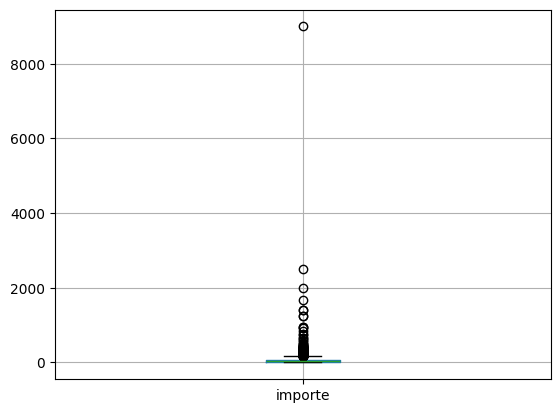

In [90]:
df_gastos.boxplot(column="importe");

In [91]:
IQR = df_gastos.importe.quantile(0.75) - df_gastos.importe.quantile(0.25)

higher_fence = df_gastos.importe.quantile(0.75) + (IQR * 1.5)

print("Valor límite de gastos para atípicos: ", higher_fence)

Valor límite de gastos para atípicos:  163.14625


Remove outliers

In [92]:
df_gastos_nooutliers = df_gastos[df_gastos.importe < higher_fence]

In [93]:
df_gastos_nooutliers.importe.describe([.25, .5, .75, .90, .95, .99])

count    1781.000000
mean       34.040741
std        33.348826
min         0.490000
25%         9.600000
50%        21.990000
75%        49.490000
90%        80.850000
95%       103.140000
99%       145.754000
max       163.000000
Name: importe, dtype: float64

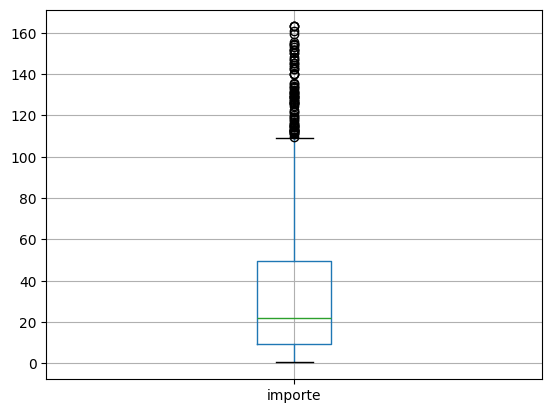

In [94]:
df_gastos_nooutliers.boxplot(column="importe");

**Expenses by month TRAMO BAJO**

In [95]:
df_gastos_nooutliers_by_month = df_gastos_nooutliers.groupby(by=["anio_valor","mes_valor"]).agg(gasto_total=("importe","sum"))

Tendencia

In [96]:
from sklearn import linear_model

reg = linear_model.LinearRegression()

X = np.arange(0,len(df_gastos_nooutliers_by_month["gasto_total"])).reshape(-1, 1)
y = df_gastos_nooutliers_by_month["gasto_total"].values

tendencia = reg.fit(X,y).predict(X)


Plot

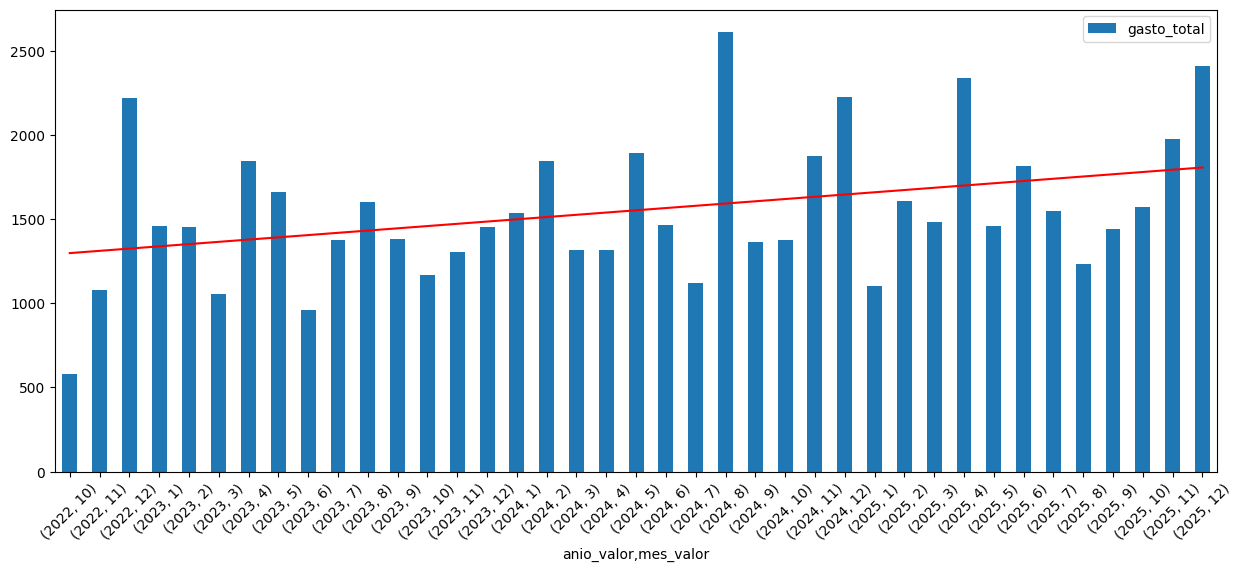

In [97]:
df_gastos_nooutliers_by_month.plot.bar(rot=45, figsize=(15,6));
plt.plot(X, tendencia, color="red")
plt.xticks(range(len(df_gastos_nooutliers_by_month.gasto_total)),df_gastos_nooutliers_by_month.index, rotation=45)
plt.show();

In [98]:
minimo = float(min(tendencia))
maximo = float(max(tendencia))
print(f"Tendencia - min:{minimo:.0f} max:{maximo:.0f}")

Tendencia - min:1300 max:1809


In [99]:
aumento = (maximo-minimo) / minimo
print(aumento)

0.39198346924513183


**Outliers analysis**

In [100]:
df_gastos_outliers = df_gastos[df_gastos.importe >= higher_fence]

In [101]:
df_gastos_outliers.importe.describe([.25, .5, .75, .90, .95, .99])

count     243.000000
mean      365.202510
std       618.553315
min       165.120000
25%       203.460000
50%       263.000000
75%       337.000000
90%       436.200000
95%       770.703000
99%      1868.019200
max      9000.000000
Name: importe, dtype: float64

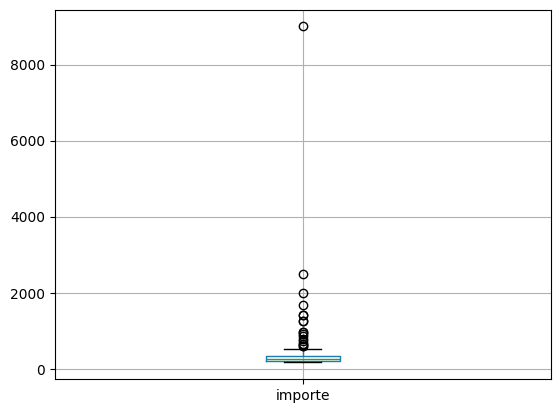

In [102]:
df_gastos_outliers.boxplot(column="importe");

Remove outliers from the outliers

In [103]:
IQR = df_gastos_outliers.importe.quantile(0.75) - df_gastos_outliers.importe.quantile(0.25)

higher_fence = df_gastos_outliers.importe.quantile(0.75) + (IQR * 1.5)

print("Valor límite de gastos para atípicos: ", higher_fence)

Valor límite de gastos para atípicos:  537.31


In [104]:
df_gastos_outliers_2 = df_gastos[df_gastos.importe < higher_fence]

**Expenses by month TRAMO ALTO**

In [105]:
df_gastos_outliers_by_month = df_gastos_outliers_2.groupby(by=["anio_valor","mes_valor"]).agg(gasto_total=("importe","sum"))

In [106]:
from sklearn import linear_model

reg = linear_model.LinearRegression()

X = np.arange(0,len(df_gastos_outliers_by_month["gasto_total"])).reshape(-1, 1)
y = df_gastos_outliers_by_month["gasto_total"].values

tendencia = reg.fit(X,y).predict(X)


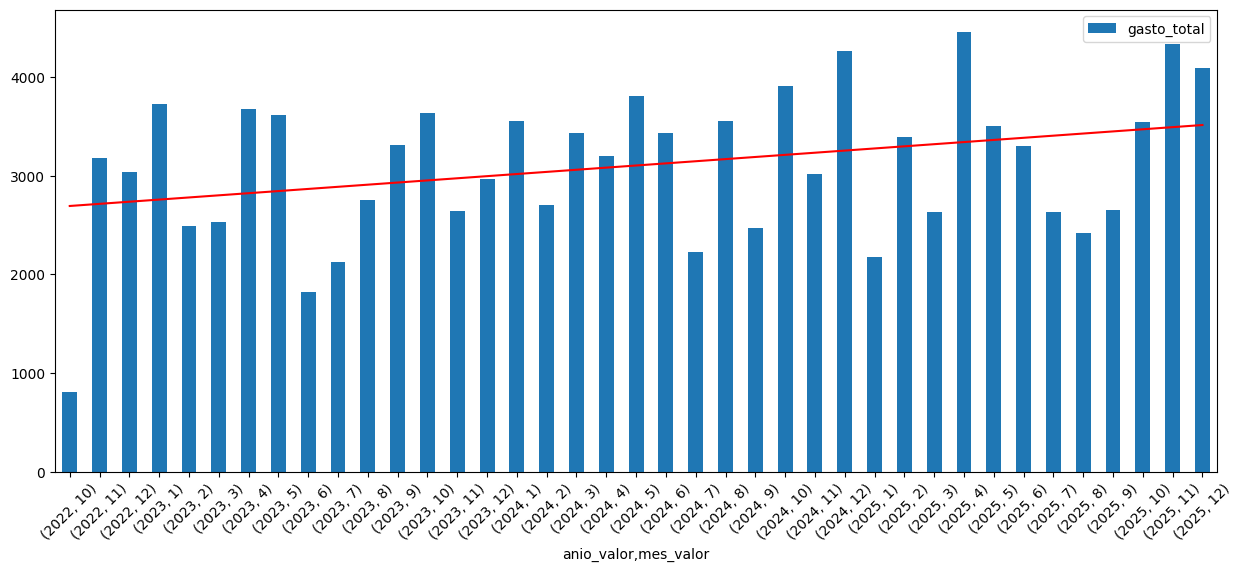

In [107]:
df_gastos_outliers_by_month.plot.bar(rot=45, figsize=(15,6));
plt.plot(X, tendencia, color="red")
plt.xticks(range(len(df_gastos_outliers_by_month.gasto_total)),df_gastos_outliers_by_month.index, rotation=45)
plt.show();

In [108]:
minimo = float(min(tendencia))
maximo = float(max(tendencia))
print(f"Tendencia - min:{minimo:.0f} max:{maximo:.0f}")

Tendencia - min:2695 max:3517


In [109]:
aumento = (maximo-minimo) / minimo
print(aumento)

0.3049126124420897


## Gastos por categoria

**Tramo bajo**

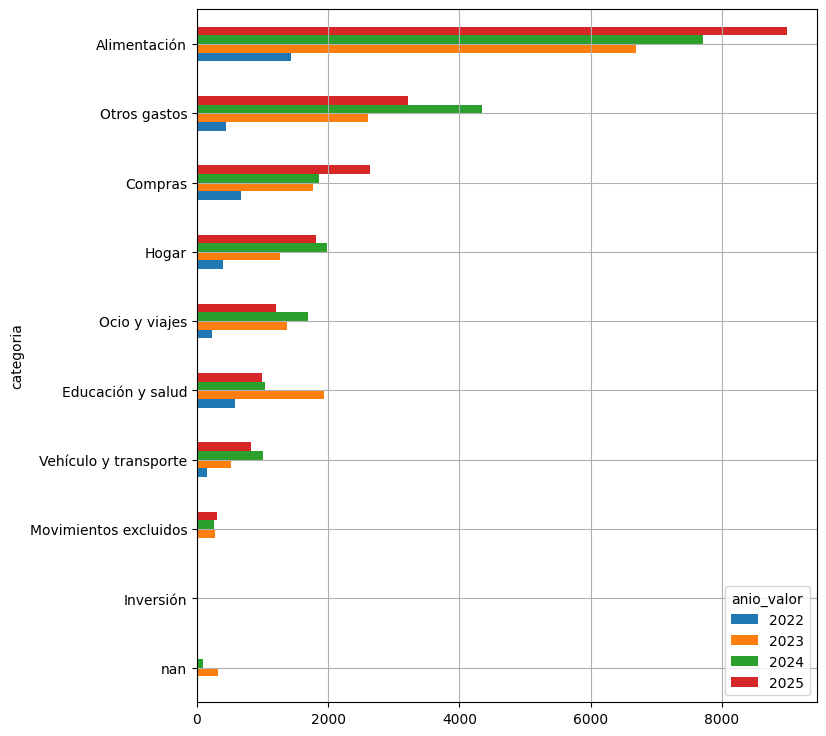

In [110]:
# Gastos por año y categoria
df_gastos_nooutliers_bycat = df_gastos_nooutliers.groupby(by=["anio_valor", "categoria"]).agg(gasto_total=("importe","sum")).reset_index()

# Pivoto por categoria y saco los años a columnas
pivot = df_gastos_nooutliers_bycat.pivot(index="categoria", columns="anio_valor", values="gasto_total").fillna(0)

pivot.sort_values(by=2025).plot.barh(grid=True, figsize=(8,9));

**Tramo alto**

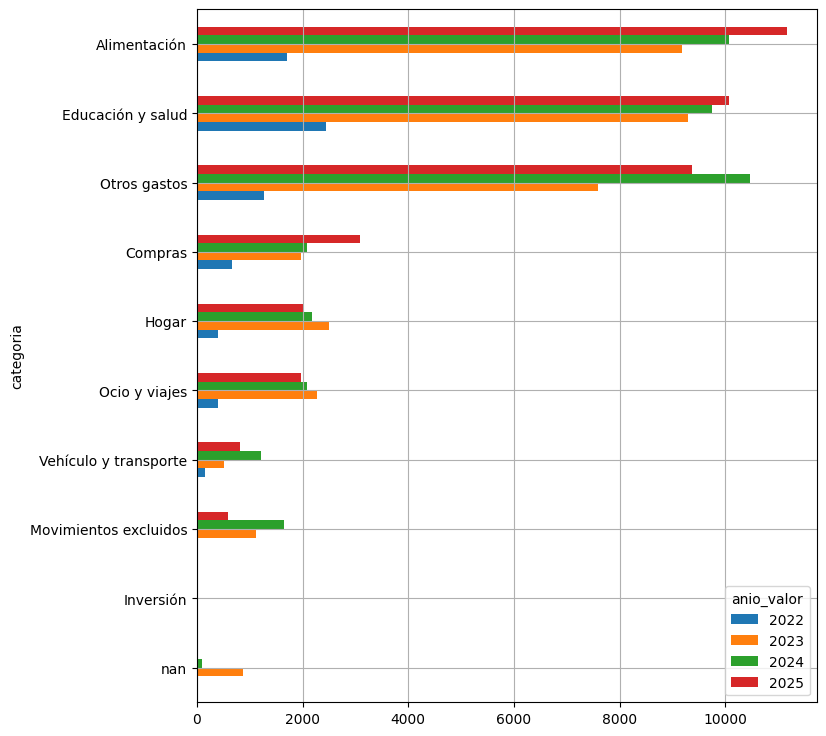

In [111]:
# Gastos por año y categoria
df_gastos_outliers_bycat = df_gastos_outliers_2.groupby(by=["anio_valor", "categoria"]).agg(gasto_total=("importe","sum")).reset_index()

# Pivoto por categoria y saco los años a columnas
pivot = df_gastos_outliers_bycat.pivot(index="categoria", columns="anio_valor", values="gasto_total").fillna(0)

pivot.sort_values(by=2025).plot.barh(grid=True, figsize=(8,9));